<a href="https://colab.research.google.com/github/danshaub/Spectography/blob/main/Music_Spec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

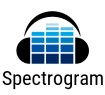
---
Analysis of music genre recognition & affective music classification
---
*Robert Farmer, Charles Filce, Dan Haub*


In [ ]:
http://colab.research.google.com/github/googlecolab/colabtools/ 

In [ ]:
#### Check GPU availability ####
#!pip install gputil
#!pip install psutil
#!pip install humanize

# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    
# Execute function
mem_report()

ModuleNotFoundError: ignored